# Welcome to an example Binder

This notebook uses `seaborn`, which we have because we included it in our `requirements.txt` file

## Setup our plotting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Setup our imports

In [2]:
from numpy import random
from scipy.ndimage.filters import gaussian_filter

## Make some plots!

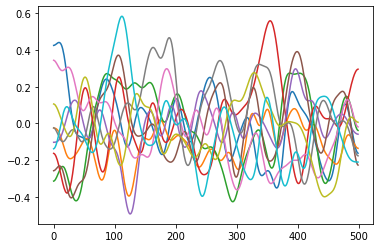

In [3]:
x = random.randn(10,500)
x = gaussian_filter(x, [0, 10])
sns.lineplot(data=x.T,dashes=False,legend=None);

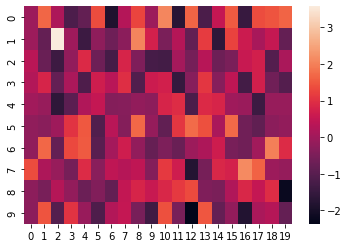

In [4]:
mat = random.randn(10,20)
sns.heatmap(mat);

## Wikipedia data mining and NLP analysis walkthrough

We are going to fetch some unstructured data (text) from Wikipedia. We'll grab the article on galaxies. Then, we will use nltk to extract the tokens from the text. We will prepare the data using pandas and, finally, visualize it with seaborn.

In [5]:
import xml.etree.ElementTree as ET

import nltk
import requests

# Download/install nltk data
nltk.download('punkt')

# Fetch the Wikipedia article on galaxies
article_url = "https://en.wikipedia.org/wiki/Galaxy"
r = requests.get(article_url)
article_html = r.text
print(f"len(article_html) == {len(article_html)}")

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


len(article_html) == 505714


At this point, we have the article content, but it's in raw HTML format.

In [6]:
tree = ET.ElementTree(ET.fromstring(article_html))
root = tree.getroot()

for element in root:
    print(f"element tag = {element.tag}; element text = {element.text}")

element tag = head; element text = 

element tag = body; element text = None


In [7]:
title = root.find("head/title")
title.text

'Galaxy - Wikipedia'

We'll target the unique div containing the article content and recurse through it, extracting the text content of all tags recursively. Each text blob is tokenized, with the tokens being added to the `token_list` variable.

In [8]:
content_div = root.find(".//div[@id='mw-content-text']")
token_list = []

def tokenize_html_text(parent_element) -> None:
    """Tokenize the text of the given element and recurse through its children"""
    
    if parent_element.text is not None:
        for token in nltk.word_tokenize(parent_element.text):
            token_list.append(token)
    
    for element in parent_element:
        tokenize_html_text(element)
        
tokenize_html_text(content_div)
len(token_list)

10539

Here's what the raw tokens look like:

In [9]:
print(token_list[0:400])

['Astronomical', 'structure', '.mw-parser-output', '.hatnote', '{', 'font-style', ':', 'italic', '}', '.mw-parser-output', 'div.hatnote', '{', 'padding-left:1.6em', ';', 'margin-bottom:0.5em', '}', '.mw-parser-output', '.hatnote', 'i', '{', 'font-style', ':', 'normal', '}', '.mw-parser-output', '.hatnote+link+.hatnote', '{', 'margin-top', ':', '-0.5em', '}', 'This', 'article', 'is', 'about', 'the', 'astronomical', 'structure', '.', 'For', 'our', 'galaxy', ',', 'see', 'Milky', 'Way', 'Galaxy', '(', 'disambiguation', ')', '.mw-parser-output', '.tmulti', '.thumbinner', '{', 'display', ':', 'flex', ';', 'flex-direction', ':', 'column', '}', '.mw-parser-output', '.tmulti', '.trow', '{', 'display', ':', 'flex', ';', 'flex-direction', ':', 'row', ';', 'clear', ':', 'left', ';', 'flex-wrap', ':', 'wrap', ';', 'width:100', '%', ';', 'box-sizing', ':', 'border-box', '}', '.mw-parser-output', '.tmulti', '.tsingle', '{', 'margin:1px', ';', 'float', ':', 'left', '}', '.mw-parser-output', '.tmulti',

You can see that there are tokens present which are related to CSS styling and HTML tag attributes. We'll need to filter those out later to minimize noise in the data, but they can stay in for now. Punctuation marks are kept in the token set.

It's time to load the extracted token dataset into a pandas dataframe.

In [10]:
import pandas as pd

df = pd.DataFrame(token_list)
df.columns = ["token"]
df.head(5)

,token
0,Astronomical
1,structure
2,.mw-parser-output
3,.hatnote
4,{


In [11]:
df["token"].value_counts()

,                      483
.                      334
;                      285
:                      225
[                      221
                      ... 
Roy                      1
Hupp                     1
.mw-selflink             1
padding-right:0.2em      1
oldid=1085134611         1
Name: token, Length: 2778, dtype: int64

In [12]:
df["token"].value_counts().head(5)

,    483
.    334
;    285
:    225
[    221
Name: token, dtype: int64

We will make a new dataframe from the value count series derived from our first dataframe. We'll set the column labels to reflect our dataset now consists of 1 row per token. Each row has a token_count representing how many times that token appears in the original article content.

In [13]:
# Reduce value counts to top n values

small_df = df["token"].value_counts().to_frame("token_count").reset_index().head(30)
small_df.columns = ["token", "token_count"]

small_df

,token,token_count
0,",",483
1,.,334
2,;,285
3,:,225
4,[,221
5,],220
6,of,212
7,the,211
8,.mw-parser-output,162
9,'',157


We will use seaborn to create a bar plot of the value counts.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, ','),
  Text(1, 0, '.'),
  Text(2, 0, ';'),
  Text(3, 0, ':'),
  Text(4, 0, '['),
  Text(5, 0, ']'),
  Text(6, 0, 'of'),
  Text(7, 0, 'the'),
  Text(8, 0, '.mw-parser-output'),
  Text(9, 0, "''"),
  Text(10, 0, '^'),
  Text(11, 0, '``'),
  Text(12, 0, '('),
  Text(13, 0, ')'),
  Text(14, 0, '{'),
  Text(15, 0, '}'),
  Text(16, 0, 'Retrieved'),
  Text(17, 0, 'galaxies'),
  Text(18, 0, 'and'),
  Text(19, 0, 'Archived'),
  Text(20, 0, 'a'),
  Text(21, 0, 'galaxy'),
  Text(22, 0, 'The'),
  Text(23, 0, 'in'),
  Text(24, 0, 'Galaxy'),
  Text(25, 0, 'Bibcode'),
  Text(26, 0, 'Galaxies'),
  Text(27, 0, 'to'),
  Text(28, 0, 'doi'),
  Text(29, 0, '..')])

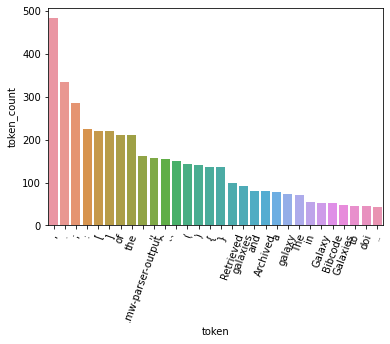

In [14]:
import matplotlib.pylab as plt

bar_plot = sns.barplot(x="token", y="token_count", data=small_df)

plt.xticks(rotation=70)

And there you have it!

This walkthrough showed you how to:
- Mine some unstructured text from the internet
- Parse and tokenize the text
- Load the tokens into a pandas DataFrame
- Summarize the token dataset using a pandas Series
- Visualize the token frequencies using seaborn
- Share your process, findings, and visualizations with the world using binder

Congratulations! 🎉

In future walkthroughs, I'll cover:
- Improving data quality for mined, unstructured datasets through filtering (tag matching, non-alphanumeric token removal)